In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import sys 
sys.path.insert(0, '../src/')
import jsm_mcmc
import jsm_SHMR

import warnings; warnings.simplefilter('ignore')

selecting a paramtrization of the SHMR and reading in the data

In [2]:
fid_theta = [1.8, -0.2, 0.4, 10.1]
priors = [[-5, 5],[-3, 1],[0, 5], [9,12]]
params = ["a_1", "a_2", "a_3", "a_4"]
ndim = len(fid_theta)

In [3]:
datadir = "../../data/MW-analog/NvM/100/"

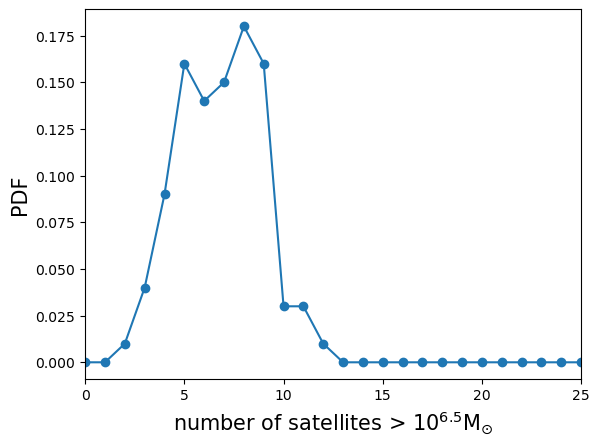

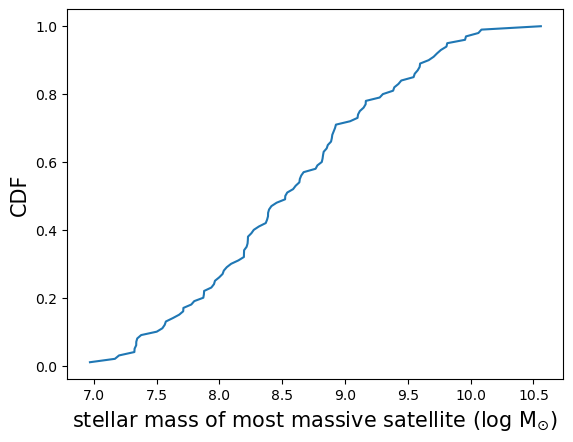

In [4]:
data = jsm_mcmc.test_data(fid_theta, datadir+"jsm_MCMC.npy", datadir+"data.npy")
data.get_stats(min_mass=6.5)

defining the foward model(s). They don't include the SAGA index selected as "data"

In [5]:
def forward(theta):
    models = jsm_mcmc.models(theta, jsm_SHMR.anchor, data.lgMh_models)
    models.get_stats(min_mass=6.5)
    return models.stat.Pnsat, models.stat.Msmax, models.stat.ecdf_MsMax

defining the log likelyhood

In [6]:
def lnlike(theta):
    model_Pnsat, models_Msmax, _ = forward(theta)
    lnL_sat = jsm_mcmc.lnL_Pnsat(model_Pnsat, data.stat.satfreq)
    lnL_max = jsm_mcmc.lnL_KS(models_Msmax, data.stat.Msmax)
    return lnL_sat + lnL_max

def lnprior(theta):
    if priors[0][0] < theta[0] < priors[0][1] and priors[1][0] < theta[1] < priors[1][1] and priors[2][0] < theta[2] < priors[2][1]:
        lp = 0
    else:
        lp = -np.inf
    chi2_pr = ((theta[3] - 10.0) / 0.2) ** 2
    lnLPR = -chi2_pr / 2.0
    return lnLPR + lp

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + lnlike(theta)

intializing the run!

In [7]:
nwalk = 100
nsteps = 500
ndim = len(fid_theta)
start_theta = [1.4, -0.3, 1, 10] # a somewhat random starting place

RUNNING!

In [8]:
mcmc_out = jsm_mcmc.RUN(start_theta, lnprob, nwalkers=nwalk, niter=nsteps, ndim=ndim, ncores=8)

KeyboardInterrupt: 

In [ ]:
run = jsm_mcmc.inspect_run(mcmc_out, fid_theta=data.fid_theta, labels=params, priors=priors, savedir=datadir, data=data, SHMR=jsm_SHMR.anchor, forward=forward)